# 28th of June, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Poliovirus DIP Project

**Paper**: Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets  
_Cell_, McCarroll Lab, (2015)  
* 
## Paper will be read after image analysis

## Analyze bulk droplets
Each 8-bit image, both 4X and 10X, has two channels; brightfield and GFP. The GFP channel reports either the TIP or WT virus, so cells need to be determined from brightfield. This may not be necessary in the future if DAPI or cytosol markers are introduced to the HeLa cells, but for now cells will be segmented from brightfield. The goal is to collect the number of cells per droplet and from those cell determine the ones that are alive or dead and infected or not.

### Defined Droplets
As the outline of the droplets are dark, threshold the image above the intensity of the outlines. From the black white images, fill if necessary (as cells show up dark) to create a droplet region. Since inter-droplet space will also be picked up, the regions need to be filtered for ellipicity (should be low). Filtered regions will should include all droplets.  

### Determine Cells in Droplets
Cells are determined from brightfield, so values in that region lower than the Otsu threshold should encompass cells. Again filling the thresholded image should create a cell black-white mask. From the mask individual cells can be segmented through the method developed yesterday. 

### Determine if Cell is Alive and/or Infected
The segmented cells should have a certain size, a radius around 10 $\mu$m. If the size is significantly above or below this size the cell should be counted as dead. If the cell ellipticity is above 0.5, the cell is probably dead and should be counted as dead. From this sorting of dead and alive, the black-white mask of the alive cells can be applied to the GFP channel to determine the amount of fluorescence. If the fluorescence is below a certain threshold (otsu), count as uninfected. If the fluorescence is above, log it as certain level.

In [1]:
# Import packages

# Data modification
import glob
import numpy as np

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle


import skimage.filters
import skimage.io
import skimage.morphology
import skimage.exposure
import skimage.color
import skimage.segmentation
from skimage.feature import peak_local_max

from scipy import ndimage as ndi

sns.set(style='dark', palette=sns.color_palette(), rc={'axes.labelsize': 20}, font_scale=2)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
# Define the location of the image files
bulk_bright = "../data/06.27_HeLa-poliovirus/#1/4x_TRANS.tif"
bulk_gfp = "../data/06.27_HeLa-poliovirus/#1/4x_GFP.tif"

In [3]:
# Read in the images
image_bright = skimage.io.imread(bulk_bright)
image_gfp = skimage.io.imread(bulk_gfp)[:, :, 1]

In [4]:
# Threshold the GFP image and determine the value of the outline

# Create histogram data from the GFP image
hist_gfp, bins_gfp = skimage.exposure.histogram(image_gfp)

# Find the Otsu threshold
gfp_thresh_otsu = skimage.filters.threshold_otsu(image_gfp)

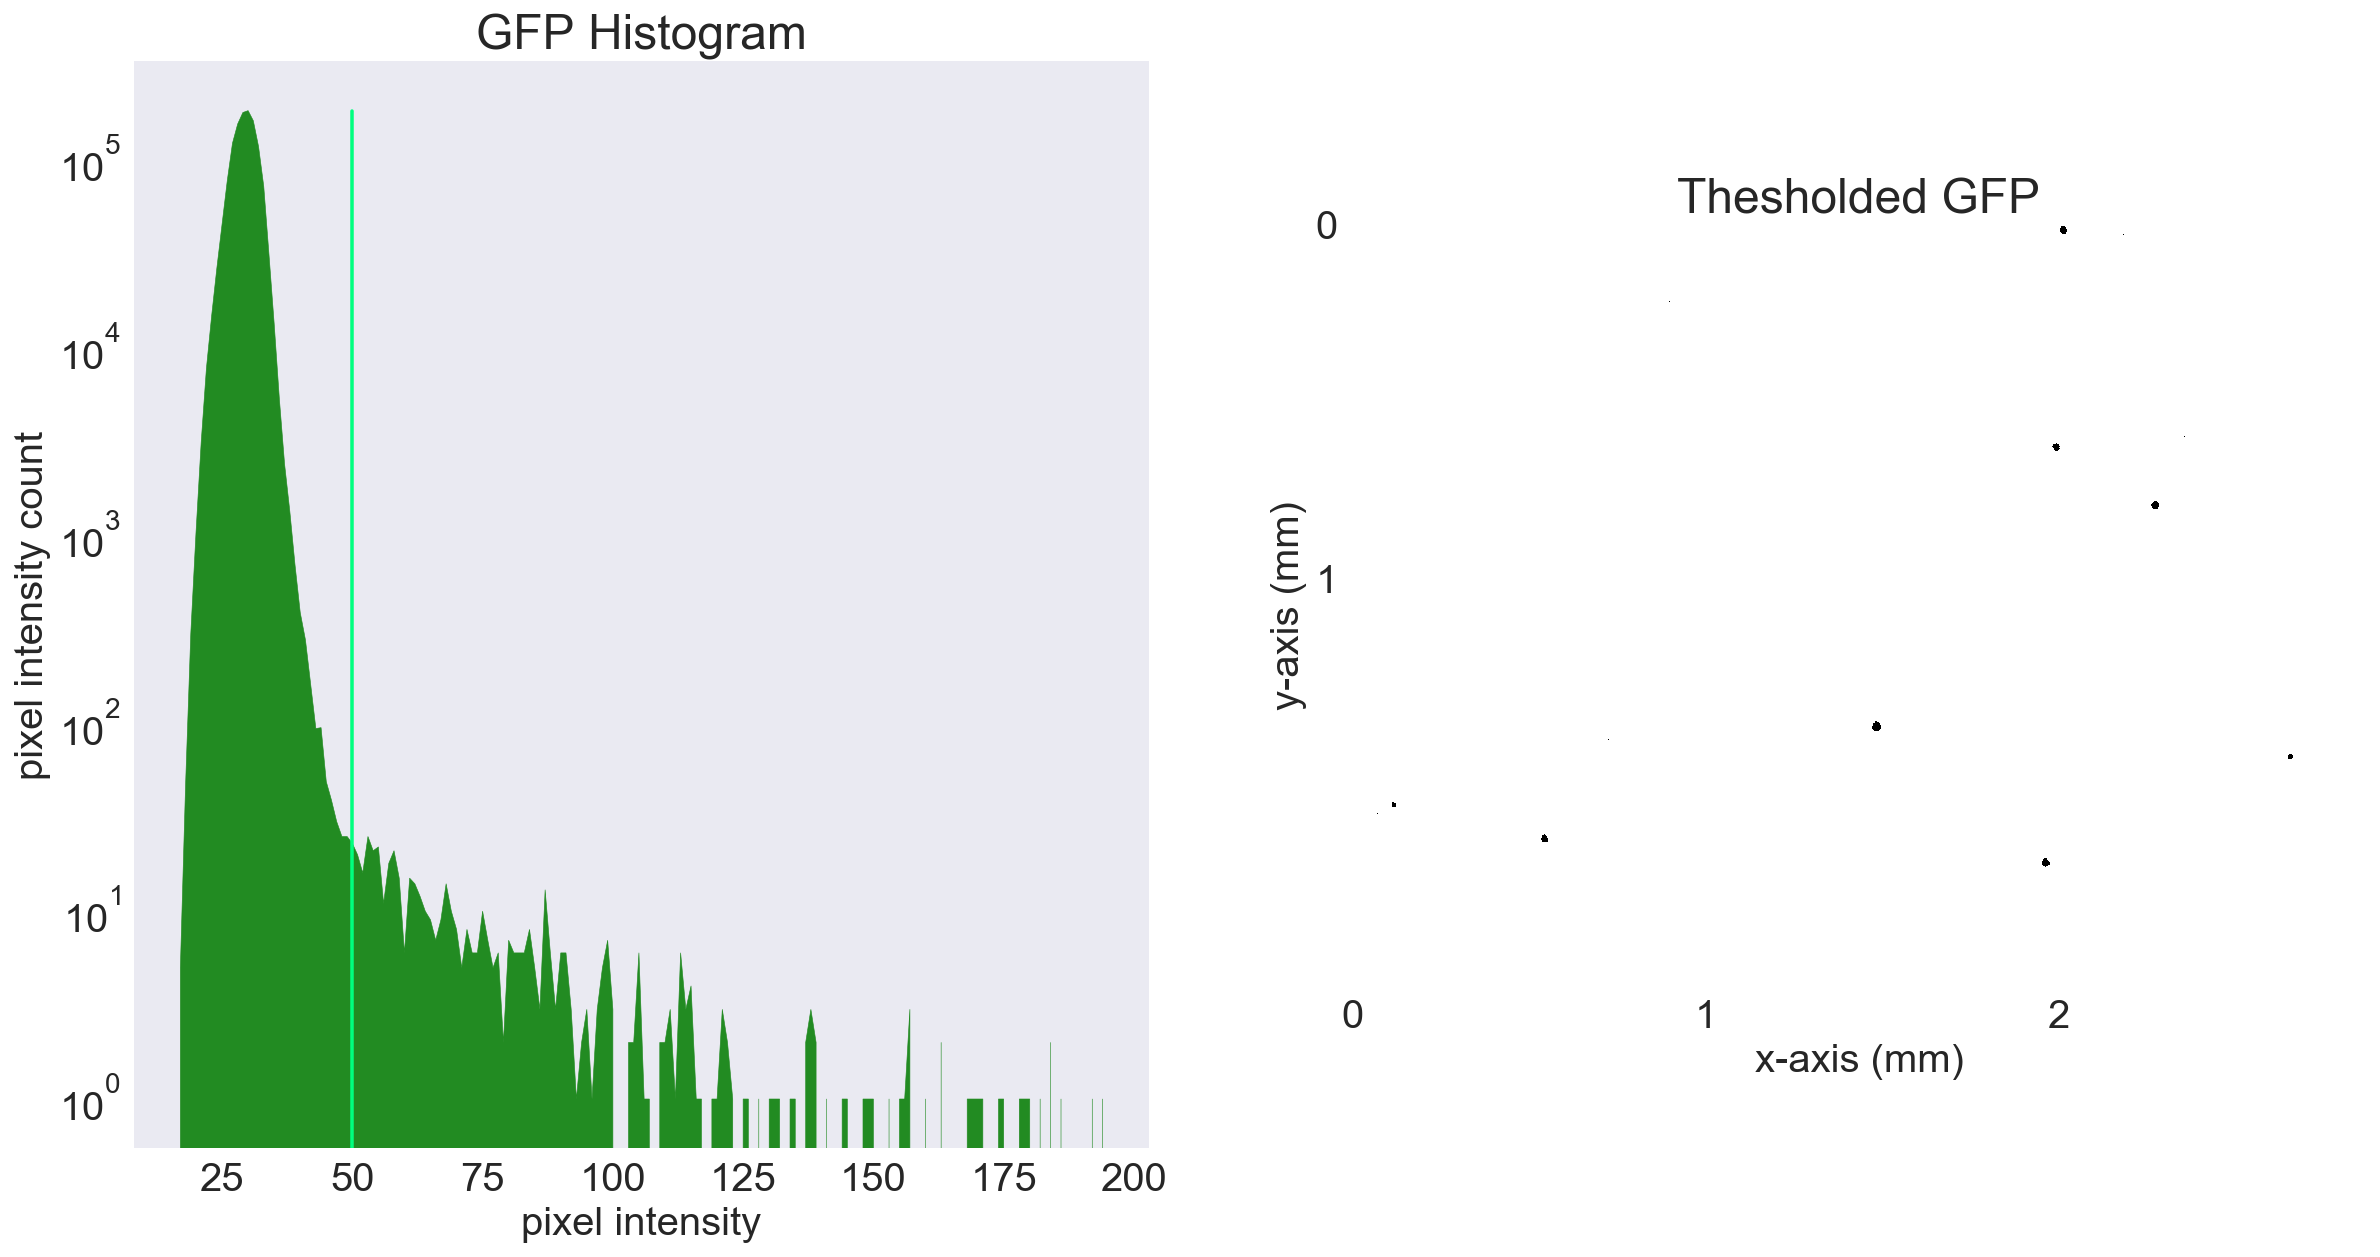

In [5]:
# Show both the histogram of the brightfield image and the thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].fill_between(bins_gfp, hist_gfp, color='forestgreen')
    ax[0].plot([50, 50],[0, max(hist_gfp)], color='springgreen')
    ax[0].set_title('GFP Histogram')
    ax[0].set_xlabel('pixel intensity')
    ax[0].set_ylabel('pixel intensity count')
    ax[0].set_yscale('log')
    
    ax[1].imshow(image_gfp > 50)
    ax[1].set_title('Thesholded GFP')
    plt.xticks(np.arange(0, 1280, 446), np.arange(0, 3, 1))
    plt.yticks(np.arange(0, 960, 446), np.arange(0, 2, 1))
    ax[1].set_xlabel('x-axis (mm)')
    ax[1].set_ylabel('y-axis (mm)')

In [6]:
# Define the filtered GFP image
gfp_filt = (image_gfp > 50) *image_gfp


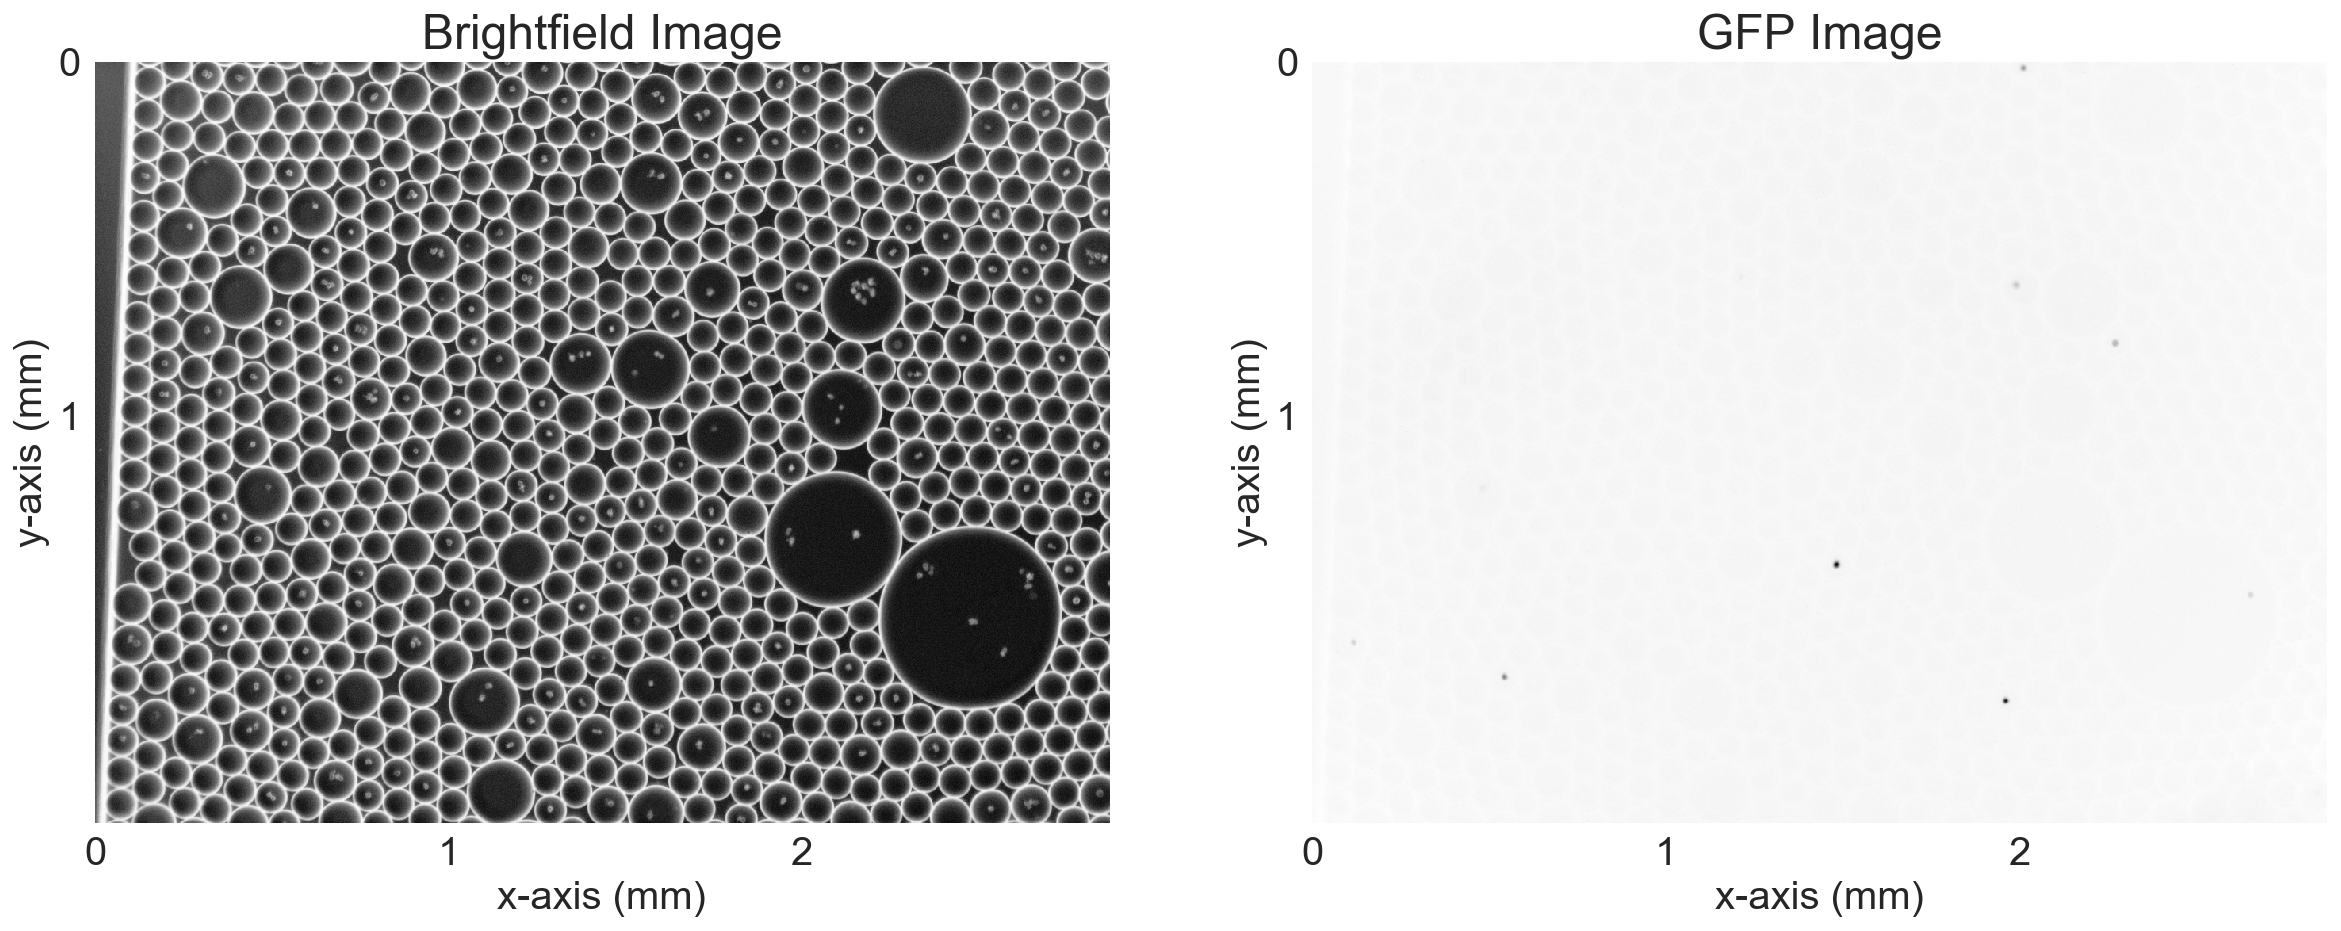

In [7]:
# Visualize the images
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(image_bright)
    ax[0].set_title('Brightfield Image')
    plt.sca(ax[0])
    plt.xticks(np.arange(0, 1280, 446), np.arange(0, 3, 1))
    plt.yticks(np.arange(0, 960, 446), np.arange(0, 2, 1))
    ax[0].set_xlabel('x-axis (mm)')
    ax[0].set_ylabel('y-axis (mm)')
    
    ax[1].imshow(image_gfp)
    ax[1].set_title('GFP Image')
    plt.sca(ax[1])
    plt.xticks(np.arange(0, 1280, 446), np.arange(0, 3, 1))
    plt.yticks(np.arange(0, 960, 446), np.arange(0, 2, 1))
    ax[1].set_xlabel('x-axis (mm)')
    ax[1].set_ylabel('y-axis (mm)')

In [8]:
# Threshold the brightfield image and determine the value of the outline

# Create histogram data from the brightfield image
hist_bright, bins_bright = skimage.exposure.histogram(image_bright)

# Find the Otsu threshold
bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

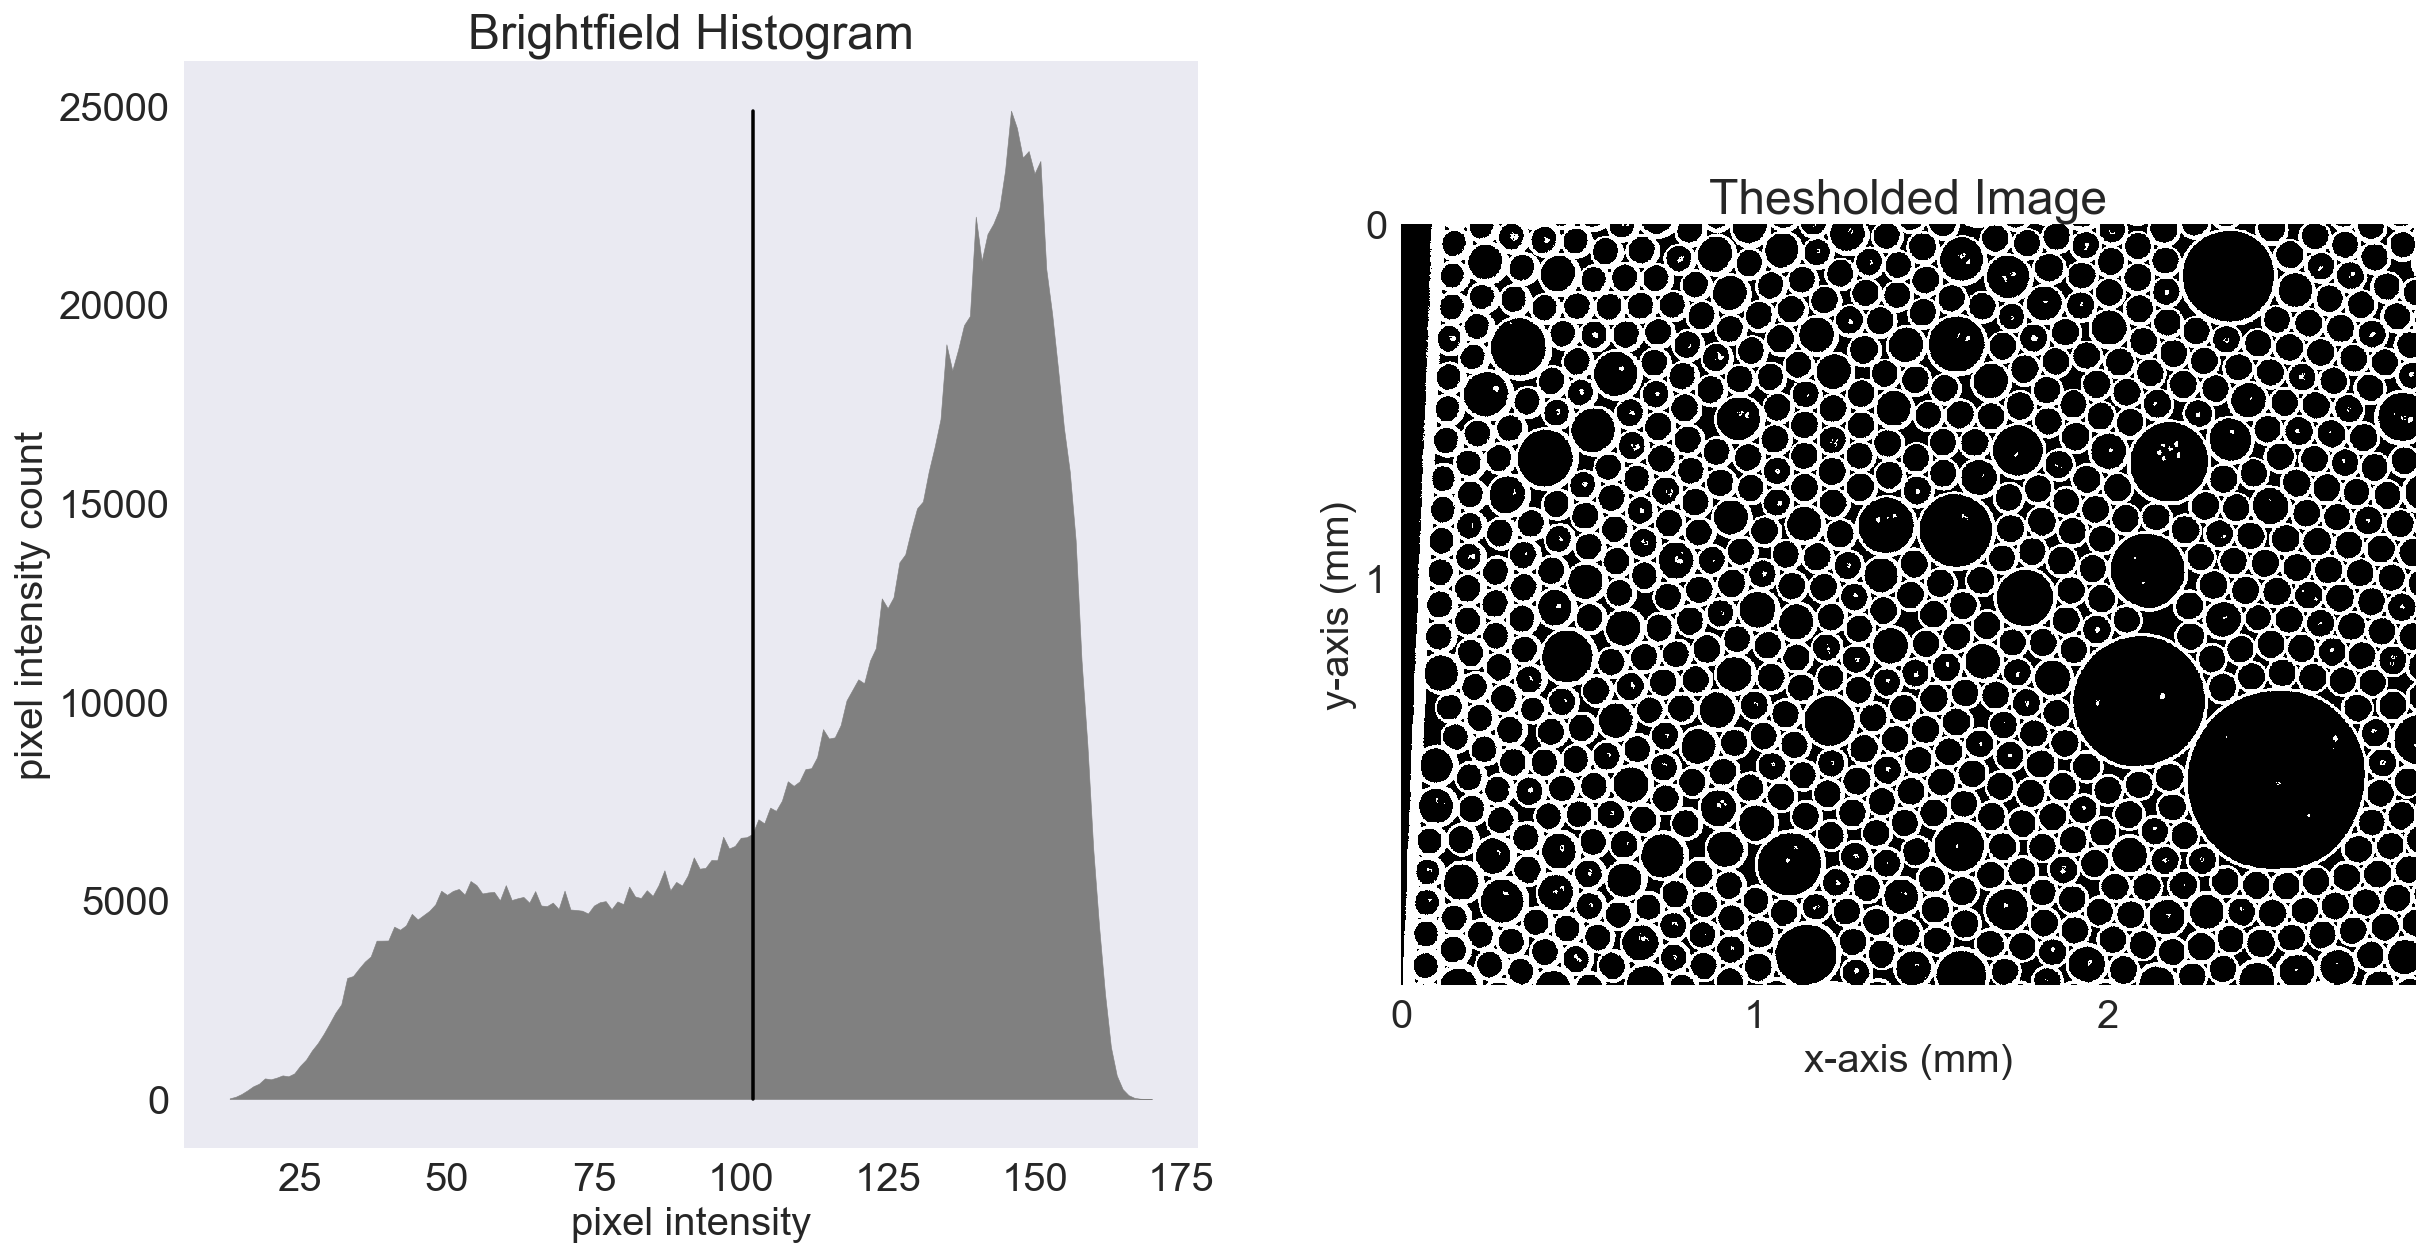

In [9]:
# Show both the histogram of the brightfield image and the thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].fill_between(bins_bright, hist_bright, color='Gray')
    ax[0].plot([bright_thresh_otsu, bright_thresh_otsu],[0, max(hist_bright)], color='black')
    ax[0].set_title('Brightfield Histogram')
    ax[0].set_xlabel('pixel intensity')
    ax[0].set_ylabel('pixel intensity count')
    
    ax[1].imshow(image_bright > bright_thresh_otsu)
    ax[1].set_title('Thesholded Image')
    plt.xticks(np.arange(0, 1280, 446), np.arange(0, 3, 1))
    plt.yticks(np.arange(0, 960, 446), np.arange(0, 2, 1))
    ax[1].set_xlabel('x-axis (mm)')
    ax[1].set_ylabel('y-axis (mm)')

In [10]:
# Label thesholded images
bright_threshold = image_bright > bright_thresh_otsu
image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)

# Get the properties of the labeled regions
image_props = skimage.measure.regionprops(image_labeled)

1683
916
0.20641186567105693


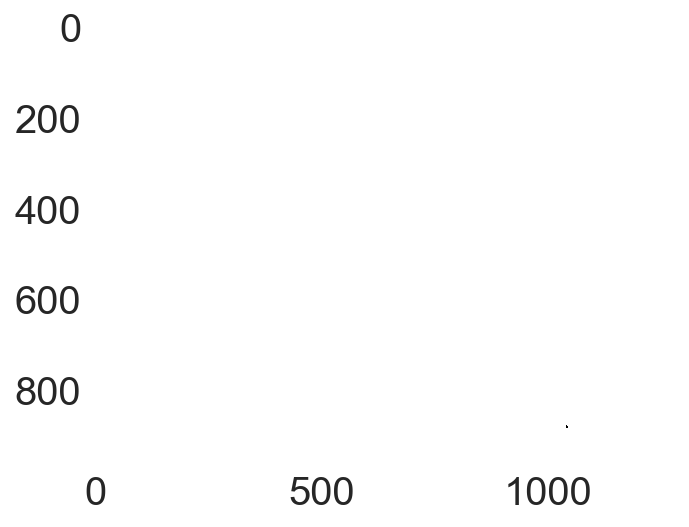

In [11]:
# Look at a sample region
with sns.axes_style('dark'):
    # Random number 
    rand_num = np.random.randint(number_labels)
    print(rand_num)
    
    temp_image = image_labeled==rand_num
    plt.imshow(temp_image)
    print(image_props[rand_num].area)
    print(image_props[rand_num].eccentricity)
    

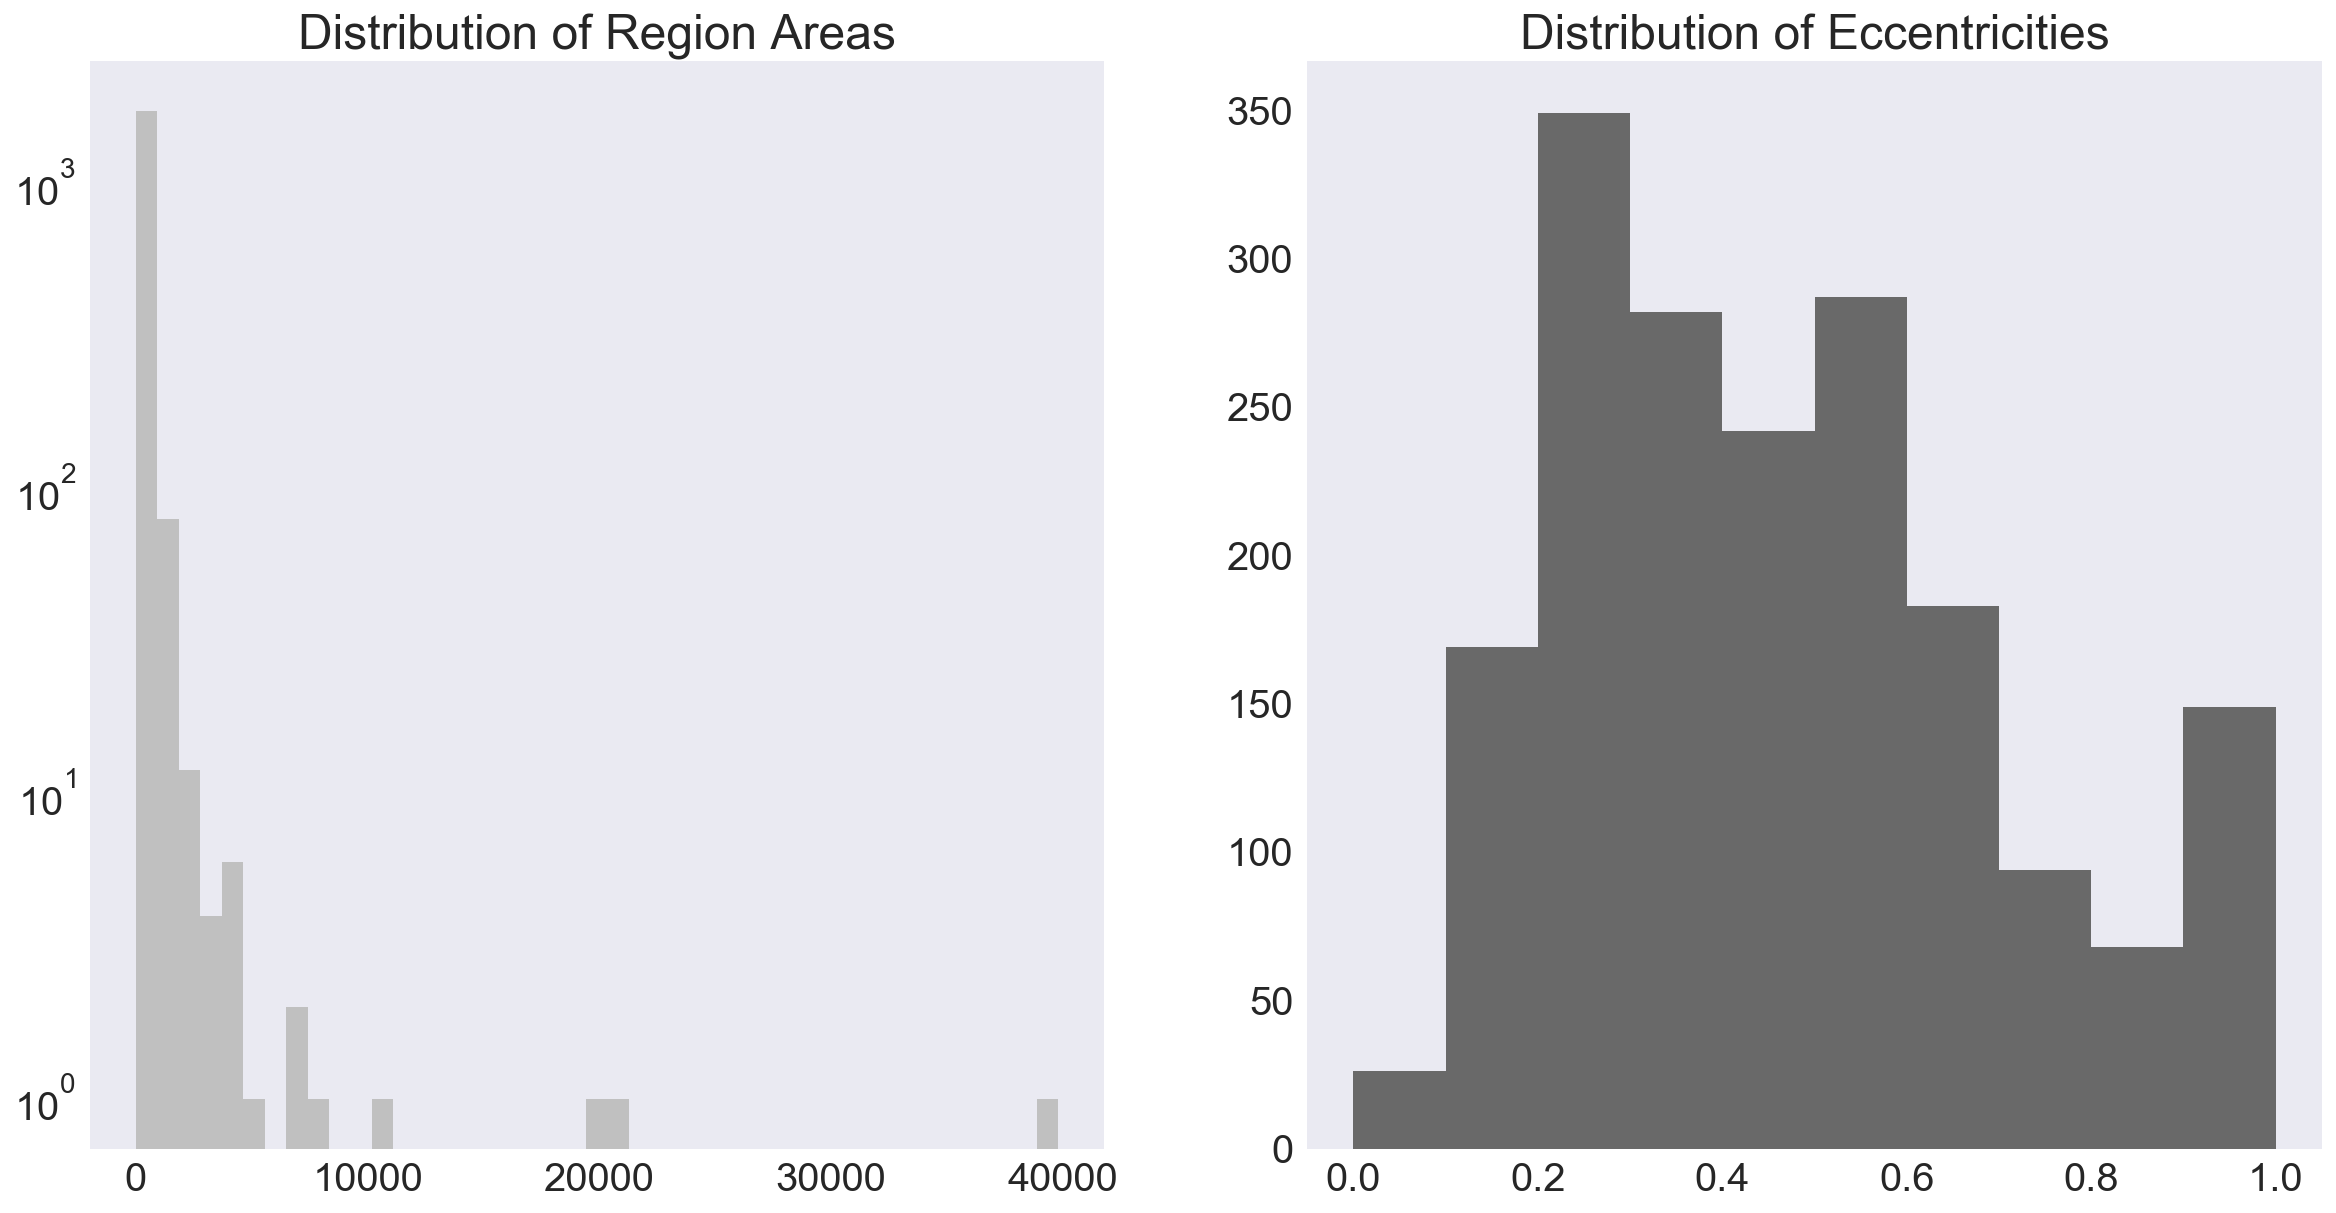

In [12]:
# Create a histogram of the region area and the eccentricity
droplet_area = [0]*number_labels
droplet_eccentricity = [0] * number_labels

for index, prop in enumerate(image_props):
    temp_area = prop.area
    temp_eccentricity = prop.eccentricity
    
    droplet_area[index] = temp_area
    droplet_eccentricity[index] = temp_eccentricity
    
# Show the two histograms
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].hist(droplet_area, bins=int(np.sqrt(len(droplet_area))), color='silver')
    ax[0].set_title("Distribution of Region Areas")
    ax[0].set_yscale('log')
    ax[1].hist(droplet_eccentricity, color= 'dimgray')
    ax[1].set_title("Distribution of Eccentricities")

It appears that the area of droplets are above 400 square pixels and eccentricities below 0.50. From these thresholds, filter the droplets.

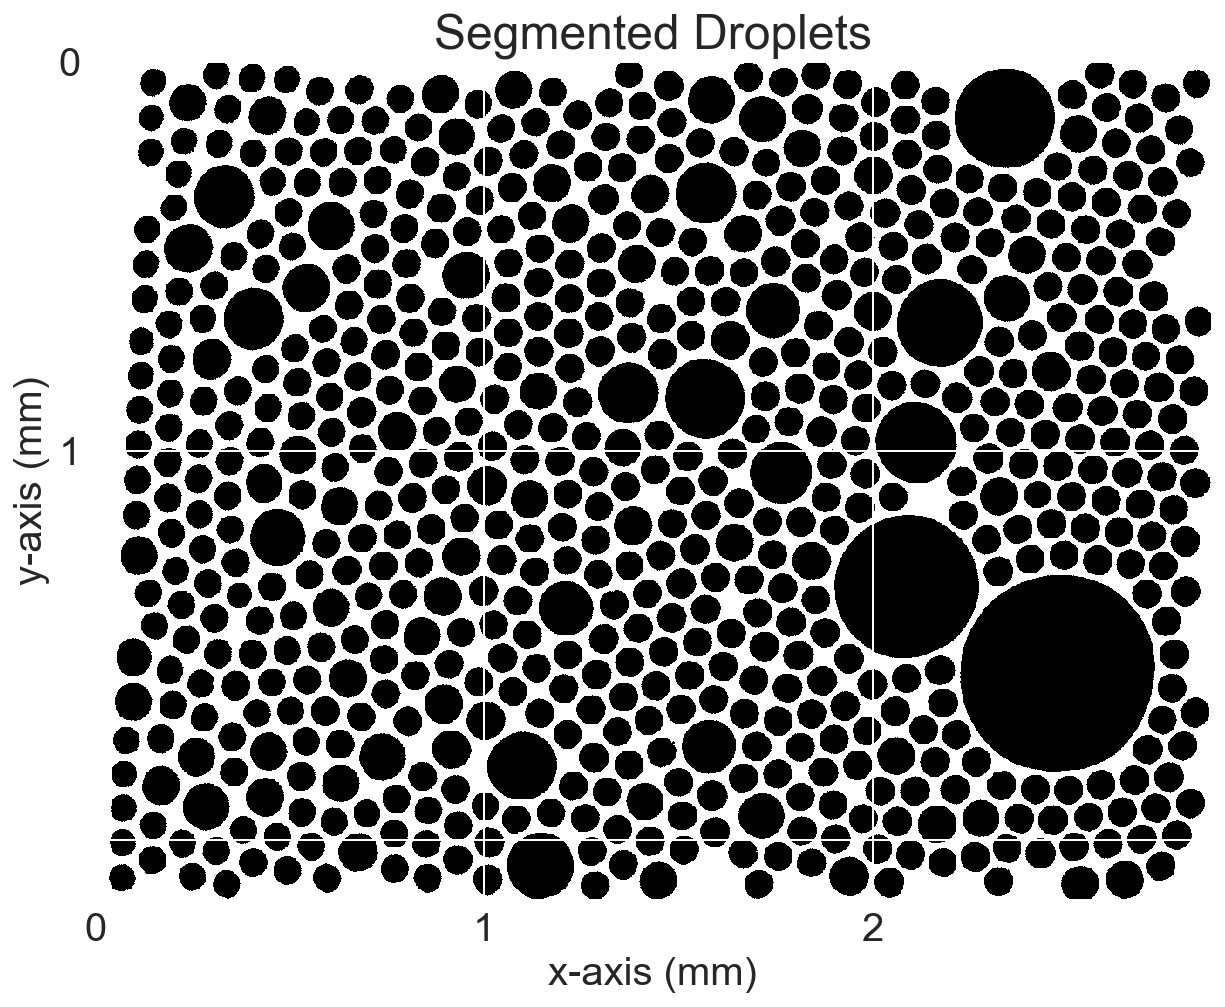

In [13]:
# Create a blank region of the original image
image_dimensions = image_bright.shape
blank_background= np.zeros(image_dimensions)

# Go through props
for index, prop in enumerate(image_props):
    # If the region properties are within the threshold
    if prop.area >= 400 and prop.eccentricity <= 0.5:
        # Select the region
        temp_seg = image_labeled==index+1
        filled_seg = temp_seg
        # Add the temp region
        blank_background = blank_background + filled_seg
        
# Fill the holes of the image
image_droplets = ndi.binary_fill_holes(blank_background)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image_droplets)
    ax.set_title("Segmented Droplets")
    plt.xticks(np.arange(0, 1280, 446), np.arange(0, 3, 1))
    plt.yticks(np.arange(0, 960, 446), np.arange(0, 2, 1))
    ax.set_xlabel('x-axis (mm)')
    ax.set_ylabel('y-axis (mm)')

In [14]:
# From the filled droplets, create labeled regions with properties
labeled_droplets, number_droplets = skimage.measure.label(image_droplets, background=0, return_num=True)
bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
gfp_droplet_props = skimage.measure.regionprops(labeled_droplets, gfp_filt)

In [15]:
# Determine the expected area of a cell
micron_in_pixel = 2.243
HeLa_radius = 10
pixel_area = HeLa_radius**2 * np.pi / (micron_in_pixel**2)
print("A HeLa cell is expected to be %d square pixels" % pixel_area)

A HeLa cell is expected to be 62 square pixels


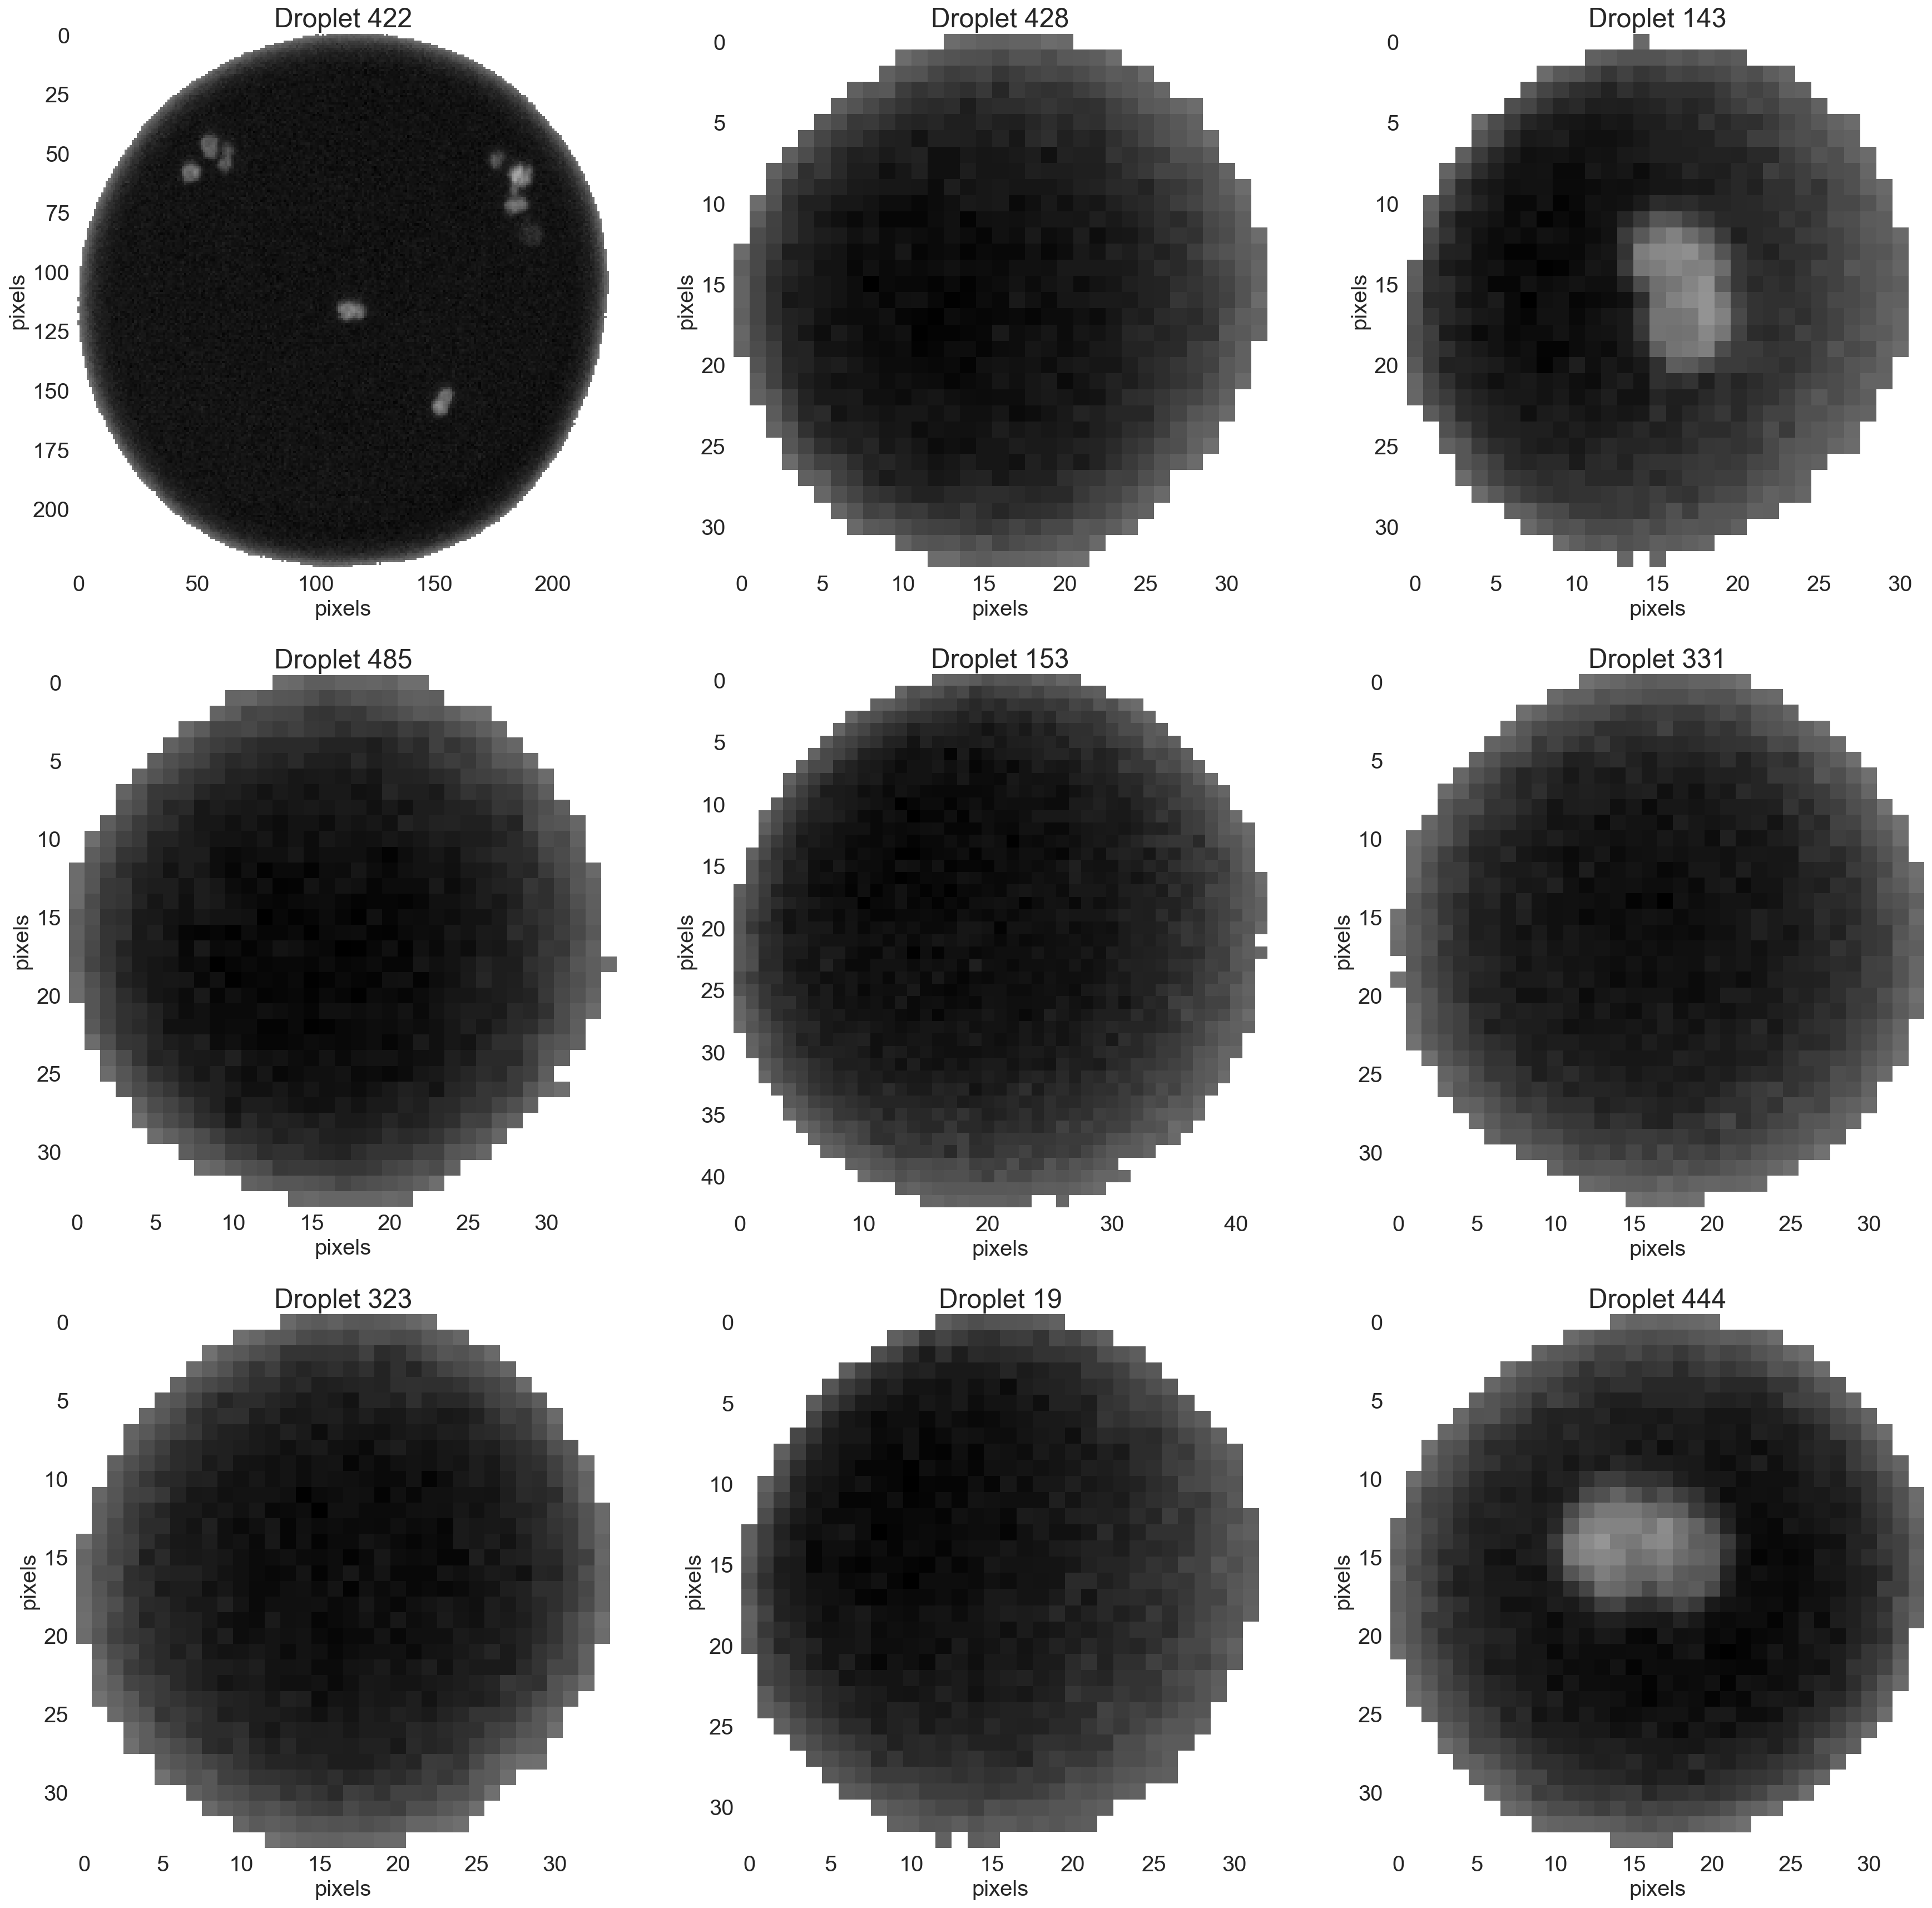

In [16]:
# Show 9 random droplets

# Choose the set of random droplets that will be tested
random_values = np.random.randint(number_droplets, size=(3,3))
# Assign the first droplet as the largest
random_values[0, 0] = 422

with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            selection = random_values[i, j]
            ax[i, j].imshow(bright_droplet_props[selection].intensity_image)
            ax[i, j].set_title("Droplet %i" % selection)
            ax[i, j].set_xlabel('pixels')
            ax[i, j].set_ylabel('pixels')


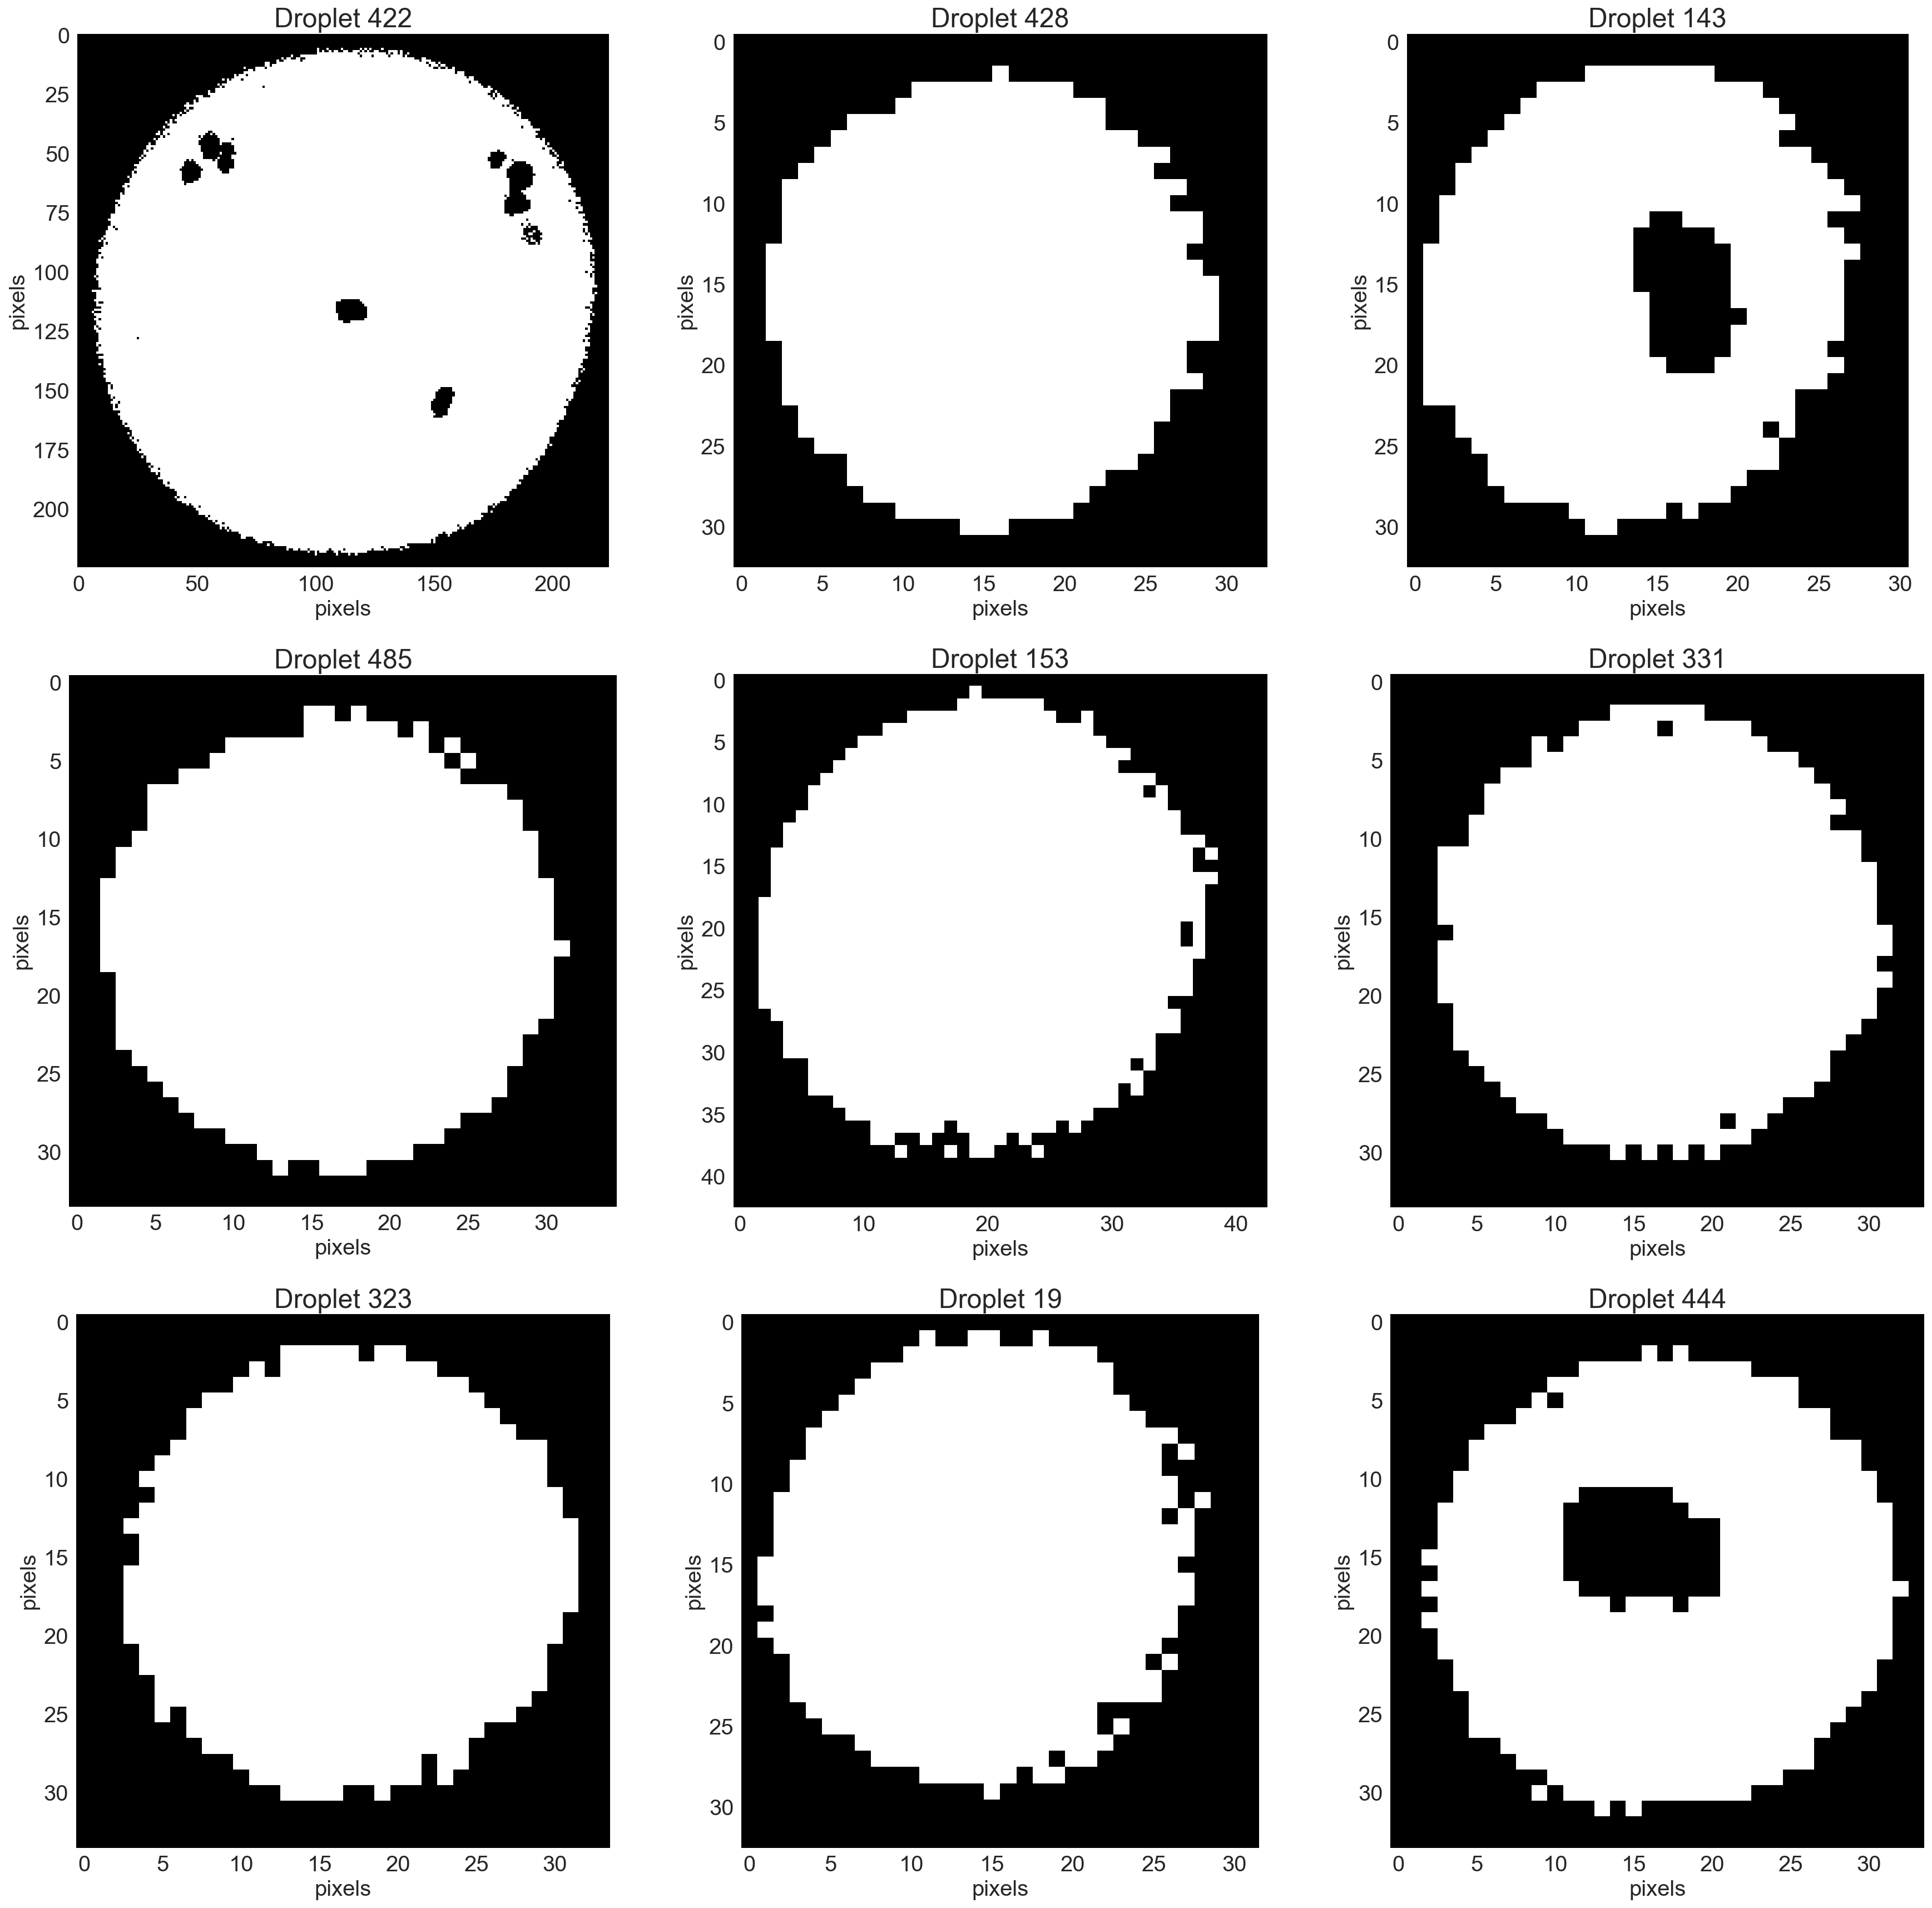

In [17]:
# Threshold the droplets to distinguish cell from droplet

# List to save black-white thesholded cells
bw_droplets = {}
gfp_droplets = {}

# Show the initial random droplets
with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            # Select droplet region
            selection = random_values[i, j]
            temp_image = bright_droplet_props[selection].intensity_image
            temp_gfp_image = gfp_droplet_props[selection].intensity_image
            
            # The background needs to be set to something that won't weight the thresholding
            temp_image[temp_image==0] = temp_image.mean()
            temp_thresh = skimage.filters.threshold_mean(temp_image)
            thresh_image = temp_image < temp_thresh
            
            # Plot the thresholded image
            ax[i, j].imshow(thresh_image)
            ax[i, j].set_title("Droplet %i" % selection)
            ax[i, j].set_xlabel('pixels')
            ax[i, j].set_ylabel('pixels')
            # Add to row 
            bw_droplets[selection] = thresh_image
            gfp_droplets[selection] = temp_gfp_image


In [20]:
# Test droplet
test_droplet = 422

# Define the test region
test_region = bw_droplets[test_droplet]
labeled_cells=segment_image(test_region)#, num_regions = skimage.measure.label(test_region, background=0, return_num=True)
bright_cell_props = skimage.measure.regionprops(labeled_cells, bright_droplet_props[test_droplet].intensity_image)
gfp_cell_props = skimage.measure.regionprops(labeled_cells, gfp_droplet_props[test_droplet].intensity_image)

In [19]:
def segment_image(temp_bw):
    """From an black-white image, return segmented image"""
    
    if thresh_image.max() != 0:
        """temp_thresh = skimage.filters.threshold_otsu(initial_image)

        temp_bw = initial_image > temp_thresh"""
        
        #temp_bw = ndi.binary_fill_holes(temp_bw)

        temp_distance = ndi.distance_transform_edt(temp_bw)

        temp_local_maxi = peak_local_max(temp_distance, labels=temp_bw, footprint=np.ones((8, 8)), indices=False)

        temp_markers = ndi.label(temp_local_maxi)[0]

        temp_labels = skimage.segmentation.watershed(-temp_distance, temp_markers, mask=temp_bw)

        return temp_labels
    else:
        return initial_image

IndexError: list index out of range

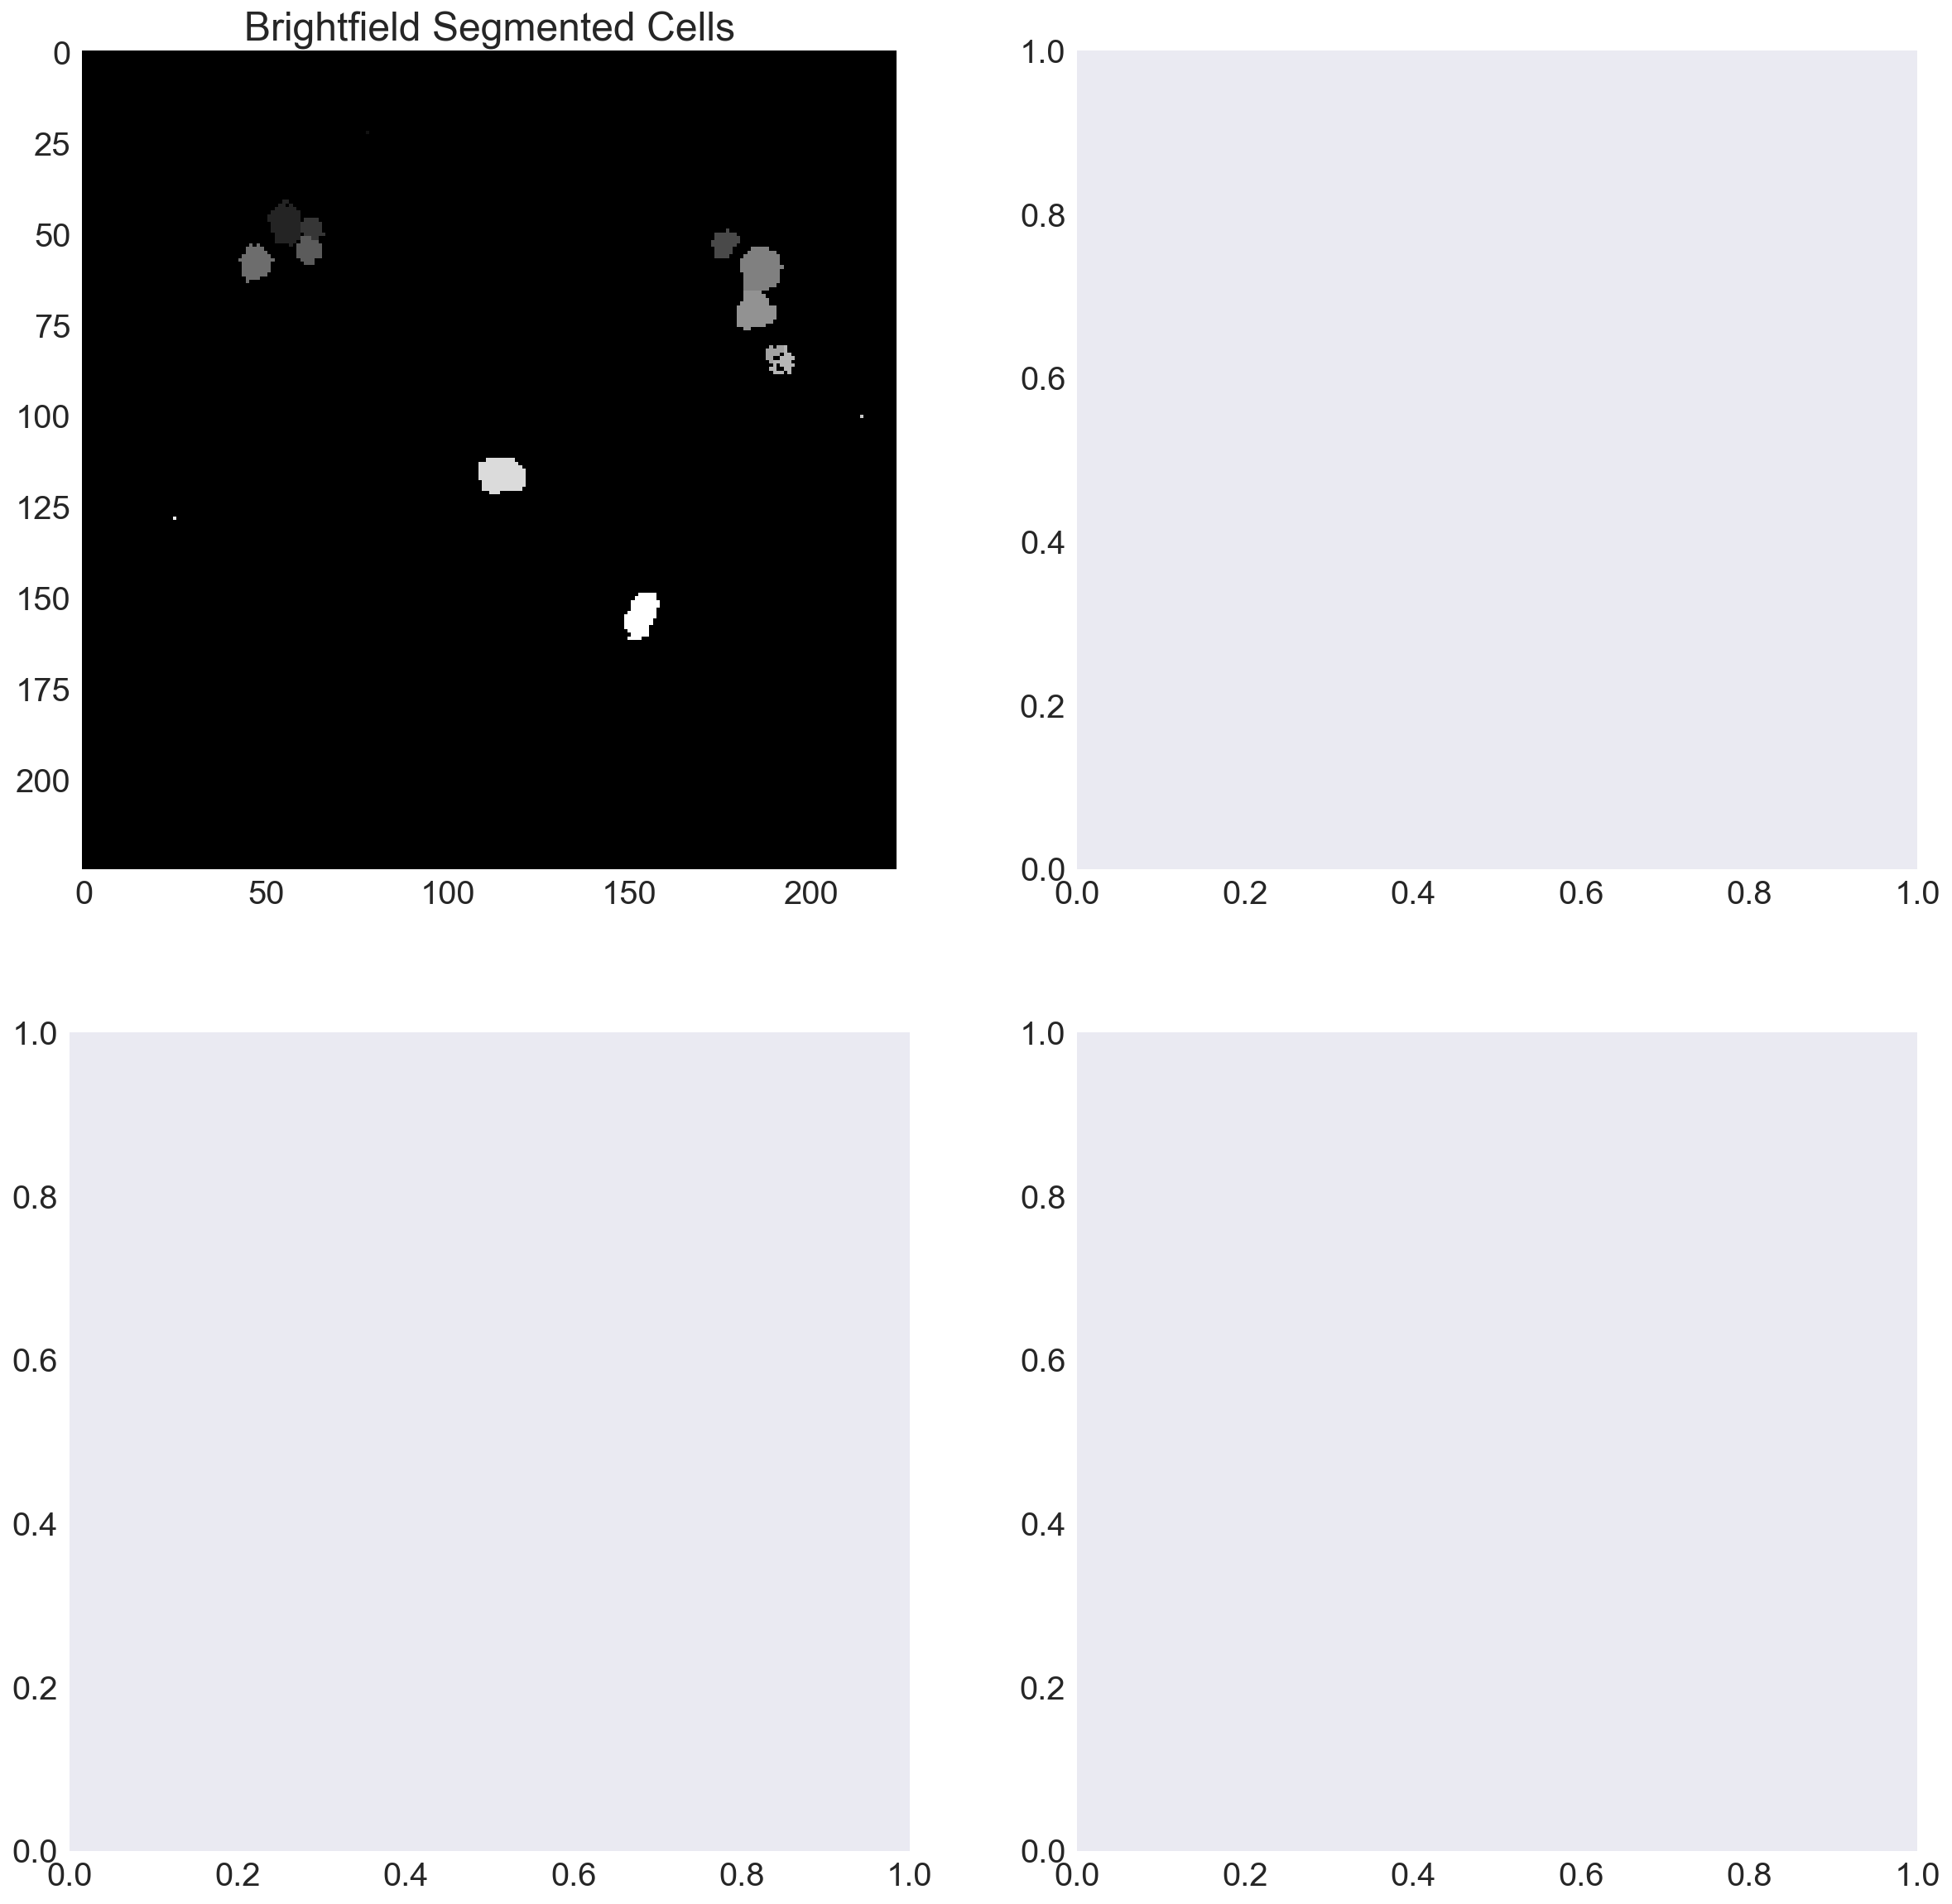

In [23]:
# Try segmentation on largest droplet

# Define the background of the GFP channel
gfp_background = image_gfp.mean()
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    
    ax[0, 0].imshow(segment_image(test_region), cmap=plt.cm.gray)
    ax[0, 0].set_title("Brightfield Segmented Cells")
    
    ax[0, 1].imshow(bright_cell_props[test_droplet].intensity_image)
    ax[0, 1].set_title("Normal Brightfield Image")
    
    ax[1, 0].imshow(gfp_cell_props[test_droplet].intensity_image)
    ax[1, 0].set_title("GFP Droplet")
    
    ax[1, 1].imshow(segment_image(test_region) * (gfp_cell_props[test_droplet].intensity_image))
    ax[1, 1].set_title("Segmented Cells GFP Channel")

In [518]:
# Determine way to tell if the cell is co-infected or not

for index, prop in enumerate(bright_cell_props):
    if prop.area > 40 and prop.area < 100 and prop.eccentricity < 0.9:
        print(index, prop.area, prop.eccentricity)
        #print(prop.eccentricity)
        #plt.imshow(prop.image_ * gfp_cell_props[index])
    

1 82 0.7030515281502104
3 43 0.5881676974808409
4 43 0.4392909714300029
5 67 0.5006586964787754
7 90 0.35520022087508274
13 89 0.829401835657936


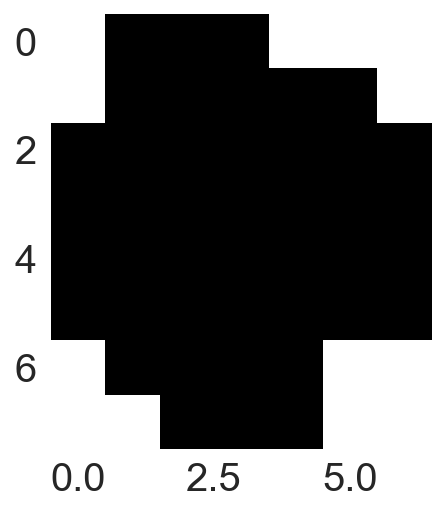

In [521]:
plt.imshow(bright_cell_props[4].image)

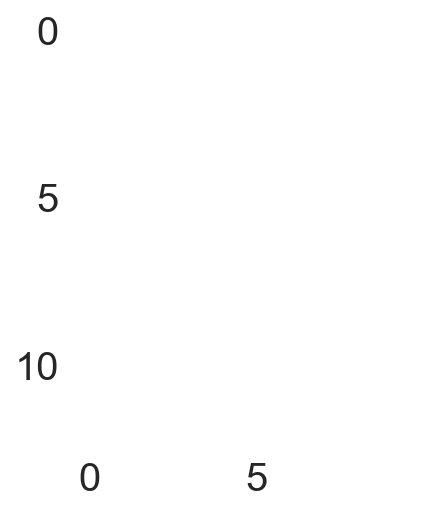

In [520]:
plt.imshow(gfp_cell_props[13].intensity_image)